European Centre for Disease Prevention and Control (na swojej stronie www organizacja ta informuje, że jest oficjalną agencją Unii Europejskiej) publikuje dane dotyczące COVID-19 dla krajów Europejskiego Obszaru Gospodarczego. Pobrałem stamtąd dane o zachorowaniach: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country (tu: https://www.ecdc.europa.eu/sites/default/files/documents/Variable_Dictionary_VaccineTracker-17-05-2022.pdf definicje wyjaśniające znaczenie tych danych) oraz dane o szczepieniach: https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea (tu: https://www.ecdc.europa.eu/sites/default/files/documents/Description-and-disclaimer_daily_reporting.pdf definicje wyjaśniające znaczenie tych danych) i wyliczyłem dla nich szereg statystyk. 

In [1]:
import numpy as np
import pandas as pd
from datetime import date
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

COUNTRY_VAC_THRESHOLD_DATE = {}
HIGH_VAC_COUNTRIES = np.array(['Niemcy','Dania','Finlandia','Francja','Włochy','Malta','Norwegia'])
LOW_VAC_COUNTRIES = np.array(['Bułgaria','Chorwacja','Czechy','Estonia','Holandia','Islandia','Litwa','Luxemburg','Polska','Rumunia','Słowacja','Słowenia','Węgry','Łotwa'])
    

def translate_country(country):
    if country == 'Belgium':
        return 'Belgia'
    elif country == 'Bulgaria':
        return 'Bułgaria'
    elif country == 'Cyprus':
        return 'Cypr'
    elif country == 'Czechia':
        return 'Czechy'
    elif country == 'Germany':
        return 'Niemcy'
    elif country == 'Denmark':
        return 'Dania'
    elif country == 'Greece':
        return 'Grecja'
    elif country == 'Spain':
        return 'Hiszpania'
    elif country == 'Finland':
        return 'Finlandia'
    elif country == 'France':
        return 'Francja'
    elif country == 'Croatia':
        return 'Chorwacja'
    elif country == 'Ireland':
        return 'Irlandia'
    elif country == 'Hungary':
        return 'Węgry'
    elif country == 'Iceland':
        return 'Islandia'
    elif country == 'Italy':
        return 'Włochy'
    elif country == 'Lithuania':
        return 'Litwa'
    elif country == 'Luxembourg':
        return 'Luxemburg'
    elif country == 'Latvia':
        return 'Łotwa'
    elif country == 'Netherlands':
        return 'Holandia'
    elif country == 'Norway':
        return 'Norwegia'
    elif country == 'Poland':
        return 'Polska'
    elif country == 'Portugal':
        return 'Portugalia'
    elif country == 'Romania':
        return 'Rumunia'
    elif country == 'Slovenia':
        return 'Słowenia'
    elif country == 'Slovakia':
        return 'Słowacja'
    elif country == 'Sweden':
        return 'Szwecja'
    return country



def hide_unused_subplots(used, size, fig):
    """
    Removes unused subplots from the given matplot figure.
    
    Parameters:
    used - index of the last used sublot
    size - number of subplots in the figure
    """
    for i in range(used, size):
        fig.axes[i].set_axis_off()
        


def find_threshold_for(df_v, country):
    """
    Searches when second dose vaccinations reaches threshold given as country population percent.
    The result is saved in global variable COUNTRY_VAC_THRESHOLD_DATE
    
    Parameters:
    df_v - data frame with Second, country, week and year columns, must by sorted by date
    country - country name
    """
    threshold = 70
    df_country_above_tr = df_v[(df_v.country == country) & (df_v.Second >= threshold)]
    if df_country_above_tr.shape[0] > 0:
        threshold_row = df_country_above_tr.iloc[0]
        COUNTRY_VAC_THRESHOLD_DATE[country] = {'week':threshold_row.week, 'year':threshold_row.year}


def find_threshold_index_for(df, country):
    """
    Looks for threshold date in COUNTRY_VAC_THRESHOLD_DATE for given country. Raises exception when data for country not present.
    """
    date = COUNTRY_VAC_THRESHOLD_DATE[country]
    return df[(df.country==country) & (df.week==date.get('week')) & (df.year==date.get('year'))].index.values[0]


def plot_threshold_line(df, country, ax, label_y):
    """
    Plots vertical line on matplot chart in place dictated by the content of COUNTRY_VAC_THRESHOLD_DATE
    """
    try:
        i = find_threshold_index_for(df, country)
        col = '0.5'
        ax.axvline(i, ls='--', color=col)
        ax.text(i,label_y,f'{tr}% populacji\nprzyjęło drugą\ndawkę', rotation=45, color=col)
    except:
        #print(f"{country} didn't reach threshold")
        pass


In [2]:
def load_weekly_cases():
    df = pd.read_csv('cases.csv')
    df['week'] = df.apply(lambda x: date(x.year,x.month,x.day).isocalendar()[1], axis=1)
    df['country'] = df.apply(lambda x: translate_country(x.countriesAndTerritories), axis=1)
    #cutoff at the 31st week of 2022 (some countries has more data)
    df = df[(df.year < 2022) | (df.week < 32)]
    #group by week
    df = df.groupby([df.country, df.geoId, df.countriesAndTerritories, df.year, df.week]).agg({
        'cases':'sum', 
        'deaths':'sum', 
        'popData2020':'median'
    })
    #moving multiindex to columns
    return df.reset_index()
    

In [3]:
def load_weekly_vaccinations():
    df = pd.read_csv('vaccination.csv')

    #There are different TargetGroup's, but ALL carries the sum
    df = df.query('TargetGroup == "ALL"')

    #Some countries reports data per region, but there always should be also a region covering whole country
    # so we need to filter out the "small" regions
    df = df.query('ReportingCountry == Region')

    df = df.assign(
        year = df['YearWeekISO'].str.split("-").str.get(0).astype("int64"),
        week = df['YearWeekISO'].str.split("-").str.get(1).str.split('W').str.get(1).astype("int64")
    )

    # Calculate FirstDose and SecondDose as a sum over all vaccination types
    df = df.groupby(['ReportingCountry','year','week']).agg({
        'FirstDose' : 'sum',
        'SecondDose' : 'sum',
        'Population' : 'median'
    })
    # TotalXxxDose as cumulative sum from first vaccination till the current (row) year and week
    df['TotalFirstDose'] = df.groupby('ReportingCountry')['FirstDose'].transform(pd.Series.cumsum)
    df['TotalSecondDose'] = df.groupby('ReportingCountry')['SecondDose'].transform(pd.Series.cumsum)

    # First and Second as a percentage of total vacinations against the whole Population
    df = df.assign(
        First = 100 * df.TotalFirstDose / df.Population,
        Second = 100 * df.TotalSecondDose / df.Population
    )
    # Moving the MultiIndex (ReportingCountry, year week) to columns 
    df = df.reset_index()
    # Adding country column
    df_c = load_weekly_cases()
    countries = dict(zip(df_c.geoId, df_c.countriesAndTerritories))
    df['country'] = df.apply(lambda x: translate_country(countries[x.ReportingCountry]), axis=1)
    return df

# Postęp programu szczepień
Poniższe wykresy pokazują jaki procent populacji kraju zaszczepiony został jedną dawką (niebieska linia), a jaki dwiema dawkami (pomarańczowa linia). Niestety do wyrysowania analogicznej krzywej dla trzech dawek zabrakło danych. Na niektórych wykresach jest dodatkowo pionowa linia wskazująca moment w którym odsetek zaszczepionych dwiema dawkami przekroczył 70%. Ma to być przybliżenie odporności populacyjnej. Aktualnie jest ona deklarowana na zdecydowanie wyższym poziomie, dochodzącym nawet do 95%, ale takich poziomów zaszczepienia nie osiągnięto. Aby więc mieć co porównywać przyjąłem wartość deklarowaną w przeszłości, gdy COVID uważano za mnie zaraźliwy. Według https://piaseczno.eu/szczepimysie-osiagnijmy-razem-zbiorowa-odpornosc/ było to 67% (źródło takie sobie, ale sama wartość progu nie jest rozstrzygająca dla analizy). Znajdujące się dalej statystyki i tak zmierzają tylko w stronę ustalenia istnienia relacji pomiędzy stopniem zaszczepienia a zachorowaniami i śmiertelnością. Osiągnięcie poziomu odporności populacyjnej powinno jedynie sprawić że relacja będzie wyraźniejsza.

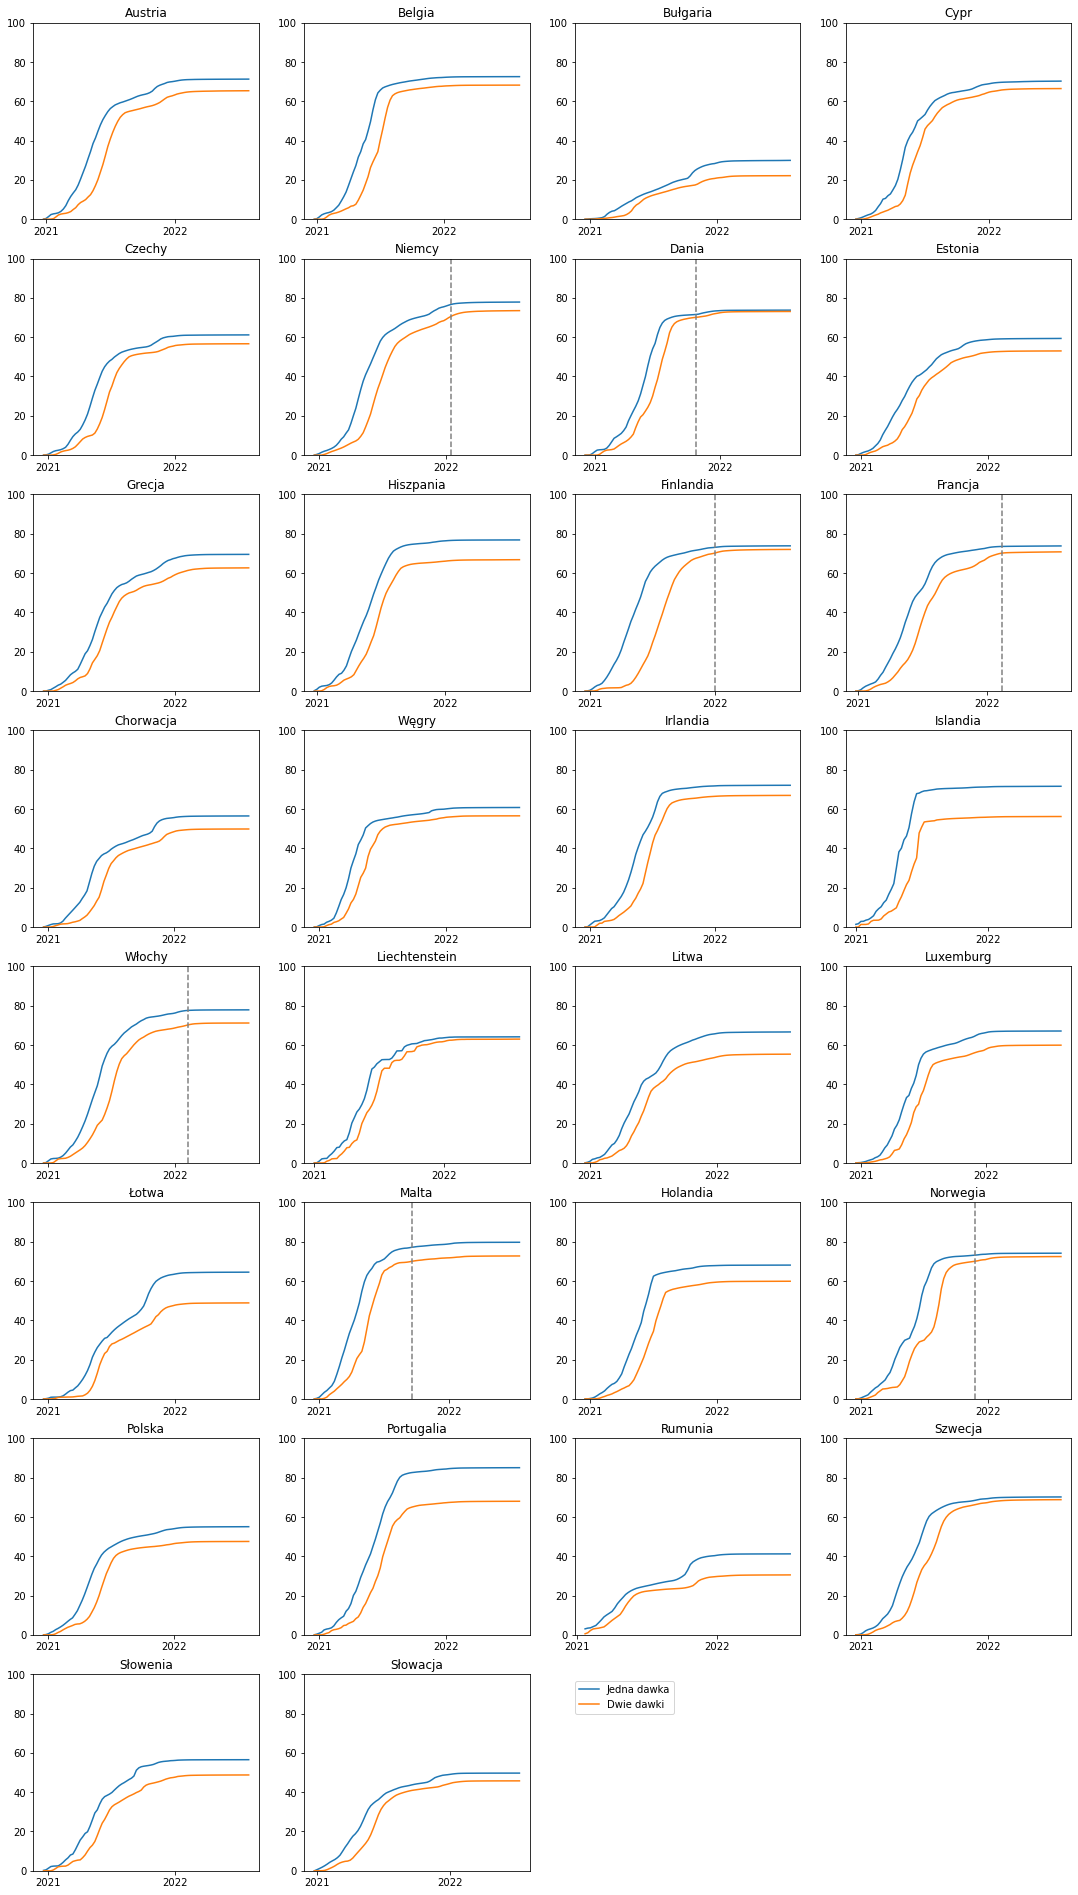

In [4]:
def plot_vaccination_progress():
    df_v = load_weekly_vaccinations()
    countries = df_v.country.unique()
    fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(18.6, 34))

    hide_unused_subplots(len(countries), 32, fig)

    for i,country in enumerate(countries, start=0):
        c = df_v[df_v.country == country]

        # shift is neccesary to not fail on coutries (Lichtenstein) with missing reading on week 1
        shift = 3
        ticks = c.index[(c.year > 2020) & (c.week == 1+shift)].tolist()
        ticks = [ t-shift for t in ticks ]

        c.First.plot(kind='line', ax=fig.axes[i])
        c.Second.plot(kind='line', ax=fig.axes[i])
        fig.axes[i].set_title(country)
        fig.axes[i].set_ylim([0,100])
        fig.axes[i].set_xticks(ticks)
        fig.axes[i].set_xticklabels(['2021','2022'])

        find_threshold_for(df_v, country)
        plot_threshold_line(df_v, country, fig.axes[i], 10)

    fig.axes[len(countries)-1].legend(['Jedna dawka', 'Dwie dawki'], loc=(1.2,0.8))

    
plot_vaccination_progress()

# Postęp zachorowań i zgonów spowodowanych COVID

Na poniższych wykresach widać jak w poszczególnych krajach wyglądała liczba zachorowań i zgonów w ujęciu tygodniowym. Zarówno zachorowania jak i zgony są przedstawione jako procent populacji kraju, którego dotyczą, dzięki czemu można porównywać dane opisujące kraje o różnym rozmiarze. Liczba zgonów jest oczywiście o wiele mniejsza niż liczba zachorowań. Żeby więc można było dostrzec zmienność obu wielkości, są one zaprezentowane na dwóch różnych skalach. Po lewej stronie wykresu jest zawsze skala dla zachorowań, a po prawej dla zgonów. Natomiast skale nie zmieniają się pomiędzy poszczególnymi wykresami, czyli jeżeli dla jednego kraju linia jest wyżej niż dla drugiego, to znaczy to po prostu, że było więcej.

Linie dla zachorowań i dla zgonów leżą blisko siebie (mamy podobną zmienność przy uwzględnieniu różnicy skali) do mniej więcej końca 2021. Natomiast od 2022 dla niektórych krajów liczba zachorowań zaczyna mocno uciekać w górę pozostawiając w dole linię zgonów (np. Austria, Dania, Irlandia), kiedy dla innych utrzymuje się podobna relacja jak dla lat 2020 i 2021 (np. Bułgaria, Chorwacja, Hiszpania). Może być to efekt szczepienia ale jeżeli zwrócimy uwagę na to dla których krajów został osiągnięty próg zaszczepienia drugą dawką wynoszący 70% społeczeństwa oraz kiedy to nastąpiło to związek śmiertelności z poziomem zaszczepienia społeczeństwa przestaje być oczywisty. Pewnym problemem w interpretacji może być czytelność intensywnie fluktuujących z tygodnia na tydzień liczb zachorowań i zgonów. Może więc spróbujmy to zilustrować skumulowaną liczbą zachorowań i zgonów.

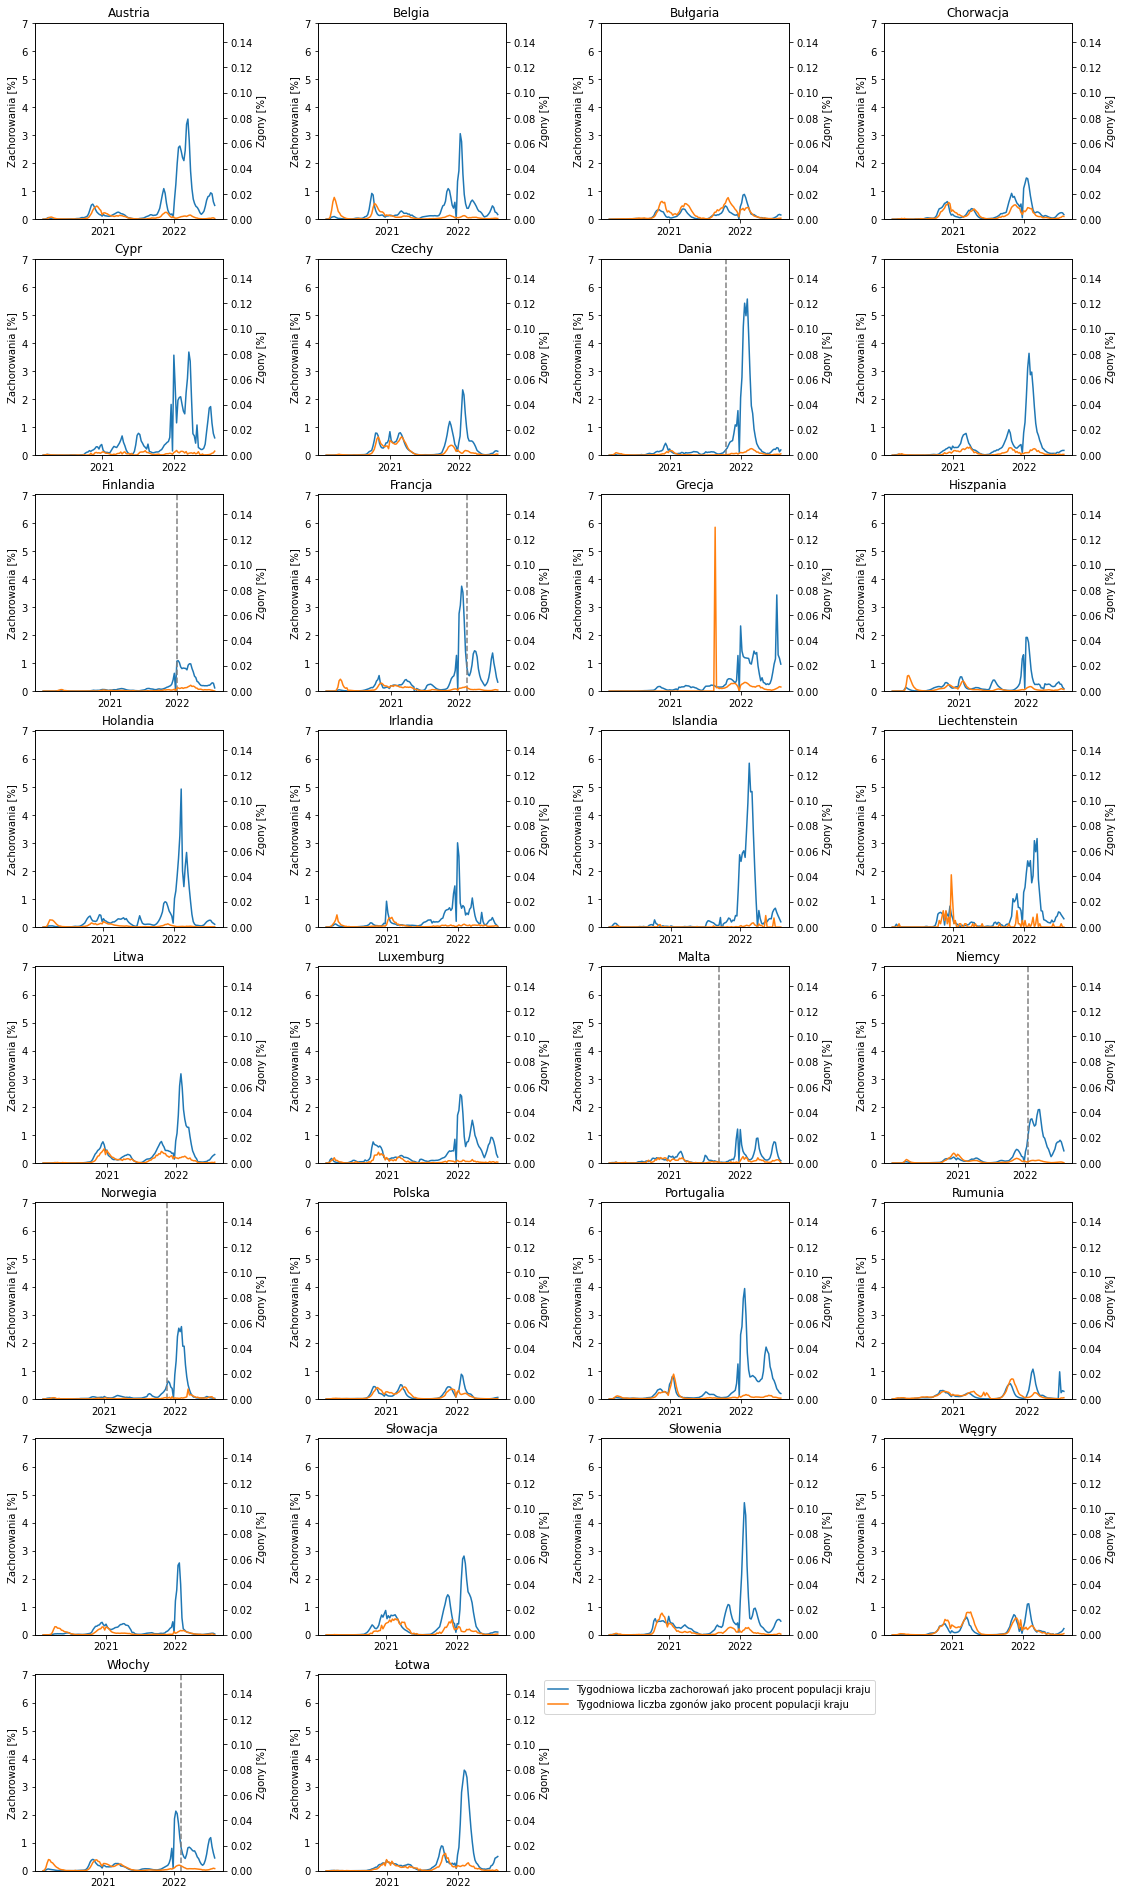

In [5]:
def plot_two_vars_per_country(first,second,df,legend_first,legend_second):

    countries = df_c.country.unique()
    fig, axes = plt.subplots(ncols=4, nrows=8, figsize=(18.6, 34))

    hide_unused_subplots(len(countries), 32, fig)
    max_y1 = df[first].max() * 1.2
    max_y2 = df[second].max() * 1.2

    for i,country in enumerate(countries, start=0):
        c = df[df.country == country]
        ticks = c.index[(c.year > 2020) & (c.week == 1)].tolist()

        c[first].plot(kind='line', ax=fig.axes[i])
        c[second].plot(kind='line', ax=fig.axes[i], secondary_y=True)
        fig.axes[i].set_title(country)
        fig.axes[i].set_ylim([0,max_y1])
        fig.axes[i].right_ax.set_ylim(0,max_y2)
        fig.axes[i].set_xticks(ticks)
        fig.axes[i].set_xticklabels(['2021','2022'])
        fig.axes[i].set_ylabel('Zachorowania [%]')
        fig.axes[i].right_ax.set_ylabel('Zgony [%]')
        plot_threshold_line(df, country, fig.axes[i], max_y1*0.75)

    ax = fig.axes[len(countries)-1]
    ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]], [legend_first, legend_second], loc=(1.2,0.8))
    fig.subplots_adjust(wspace=0.5)
   


df_c = load_weekly_cases()
df_c['CasesPrc'] = df_c.cases * 100 / df_c.popData2020
df_c['DeathsPrc'] = df_c.deaths * 100 / df_c.popData2020

plot_two_vars_per_country('CasesPrc','DeathsPrc',df_c,
                          'Tygodniowa liczba zachorowań jako procent populacji kraju',
                          'Tygodniowa liczba zgonów jako procent populacji kraju') 

Widoczne poniżej wykresy przedstawiają zależność skumulowanej liczby zachorowań oraz skumulowanej liczby zgonów liczonej od początku pandemii, a przedstawionej jako procent populacji. Sposób prezentacji jest analogiczny do tego z poprzedniej ilustracji, a w szczególności ponownie po lewej stronie wykresu jest skala dla zachorowań, a po prawej dla zgonów.

To ujęcie, tych samych danych co wcześniej, wydaje się bardziej czytelne. Dla kilku krajów, np. Dania, Francja, mamy wykresy, które można tłumaczyć pozytywnym efektem szczepień - co prawda nie zmniejszyły liczby zachorowań, ale za to sprawiły że zdecydowanie mniejszy ich odsetek kończy się zgonem. Niestety są też kraje nieco zaburzające tą jakże optymistyczną wizję (np. Malta, Włochy), a mamy również kraje w których jakby szczepionki zadziałały podobnie jak dla Danii czy Francji pomimo tego, że nie uzyskano wysokiego poziomu wszczepienia.

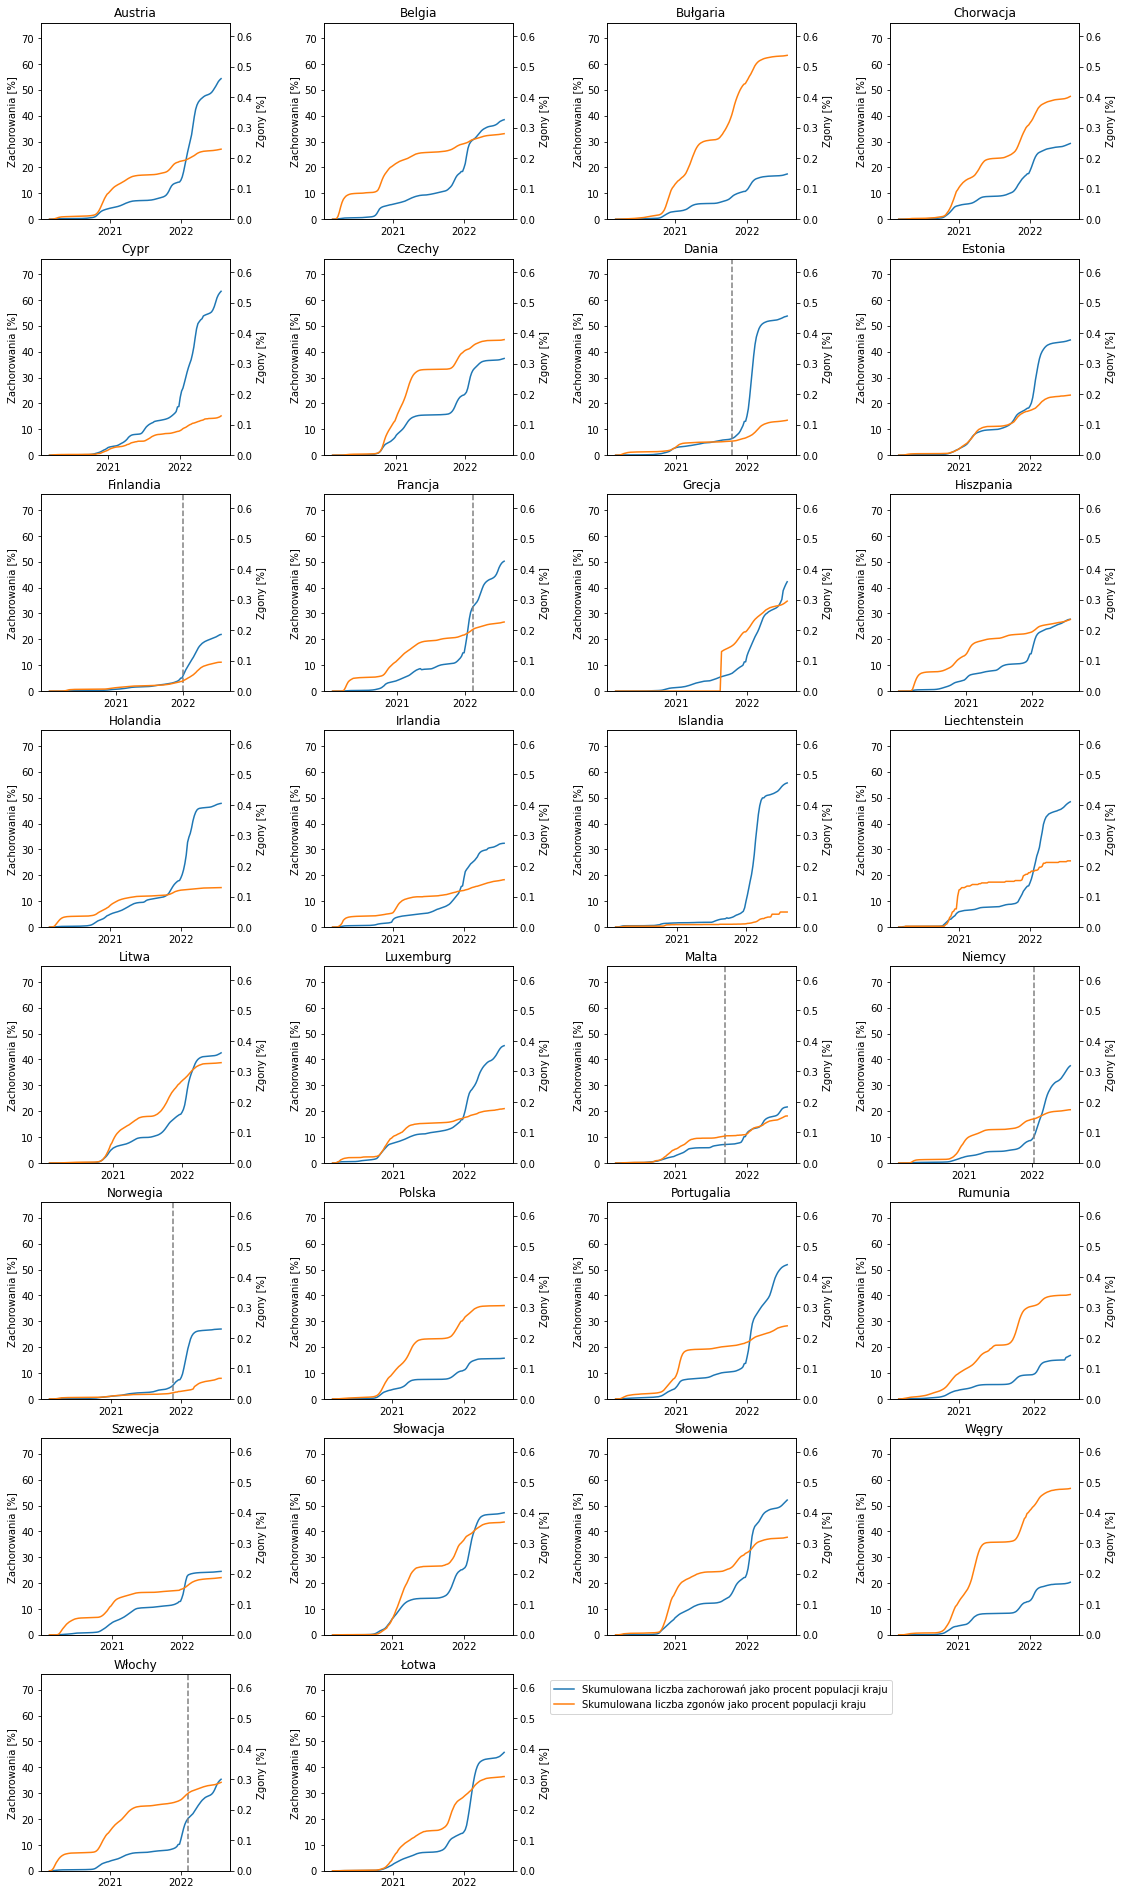

In [6]:
df_c = load_weekly_cases()
df_c['CumulativeCasesPrc'] = df_c.groupby('country')['cases'].transform(pd.Series.cumsum) * 100 / df_c.popData2020
df_c['CumulativeDeathsPrc'] = df_c.groupby('country')['deaths'].transform(pd.Series.cumsum) * 100 / df_c.popData2020

plot_two_vars_per_country('CumulativeCasesPrc',
                          'CumulativeDeathsPrc',
                          df_c,
                          'Skumulowana liczba zachorowań jako procent populacji kraju',
                          'Skumulowana liczba zgonów jako procent populacji kraju'
                          ) 

# Analiza porównawcza grupy krajów z wysokim i z niskim poziomem zaszczepienia

Spróbujmy uchwycić efekt szczepienia przy pomocy analizy porównawczej. Podzielmy więc kraje na dwie grupy. W pierwszej będą te o wysokim poziomie zaszczepienia, czyli takie które przekroczyły 70% populacji zaszczepionej dwoma dawkami na koniec badanego okresu:

|Kraj     |  Odsetek populacji |
|---------|--------------------|
|Dania    |  73.053136 |
|Finlandia|  72.033667 |
|Francja  |  70.804443 |
|Malta    |  72.700446 |
|Niemcy   |  73.486148 |
|Norwegia |  72.392949 |
|Włochy   |  71.177239 |

W drugiej grupie będą kraje o niskim poziomie zaszczepienia, to jest mniejszym niż 60% populacji:

|Kraj      | Odsetek populacji|
|----------|------------------|
|Bułgaria  | 22.122264|
|Chorwacja | 49.851165|
|Czechy    | 56.640360|
|Estonia   | 52.993682|
|Holandia  | 59.842218|
|Islandia  | 56.202683|
|Litwa     | 55.334874|
|Luxemburg | 59.907835|
|Polska    | 47.500744|
|Rumunia   | 30.491366|
|Słowacja  | 45.740424|
|Słowenia  | 48.743443|
|Węgry     | 56.547692|
|Łotwa     | 48.829905|

Grupy zostały zdefiniowane tak aby różnica pomiędzy nimi była zauważalna, w efekcie kraje o poziomie zaszczepienia w przedziale od 60% do 70% nie są uwzględnione w tej analizie.

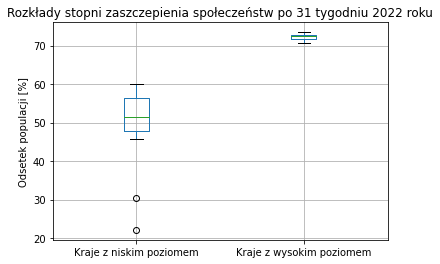

In [7]:
def plot_vaccination_level_comparison(df):
    h = df[df.country.isin(HIGH_VAC_COUNTRIES)]
    h = h.groupby(h.country).agg({'Second':'max'})

    l = df[(df.year == 2022) & df.country.isin(LOW_VAC_COUNTRIES)]
    l = l.groupby(l.country).agg({'Second':'max'})
    h['Poziom zaszczepienia'] = h.apply(lambda x: 'wysoki', axis=1)
    l['Poziom zaszczepienia'] = l.apply(lambda x: 'niski', axis=1)
    a = h.append(l)
    ax = a.groupby('Poziom zaszczepienia').boxplot(subplots=False)
    ax.set_xticks(ticks=[1,2])
    ax.set_xticklabels(['Kraje z niskim poziomem','Kraje z wysokim poziomem'])
    ax.set_title('Rozkłady stopni zaszczepienia społeczeństw po 31 tygodniu 2022 roku')
    ax.set_ylabel('Odsetek populacji [%]')
    
    
plot_vaccination_level_comparison(load_weekly_vaccinations())    


Statystyki zachorowań i zgonów dotyczą tylko 2022 roku, czyli okresu kiedy już poziom zaszczepienia się ustabilizował. Dane kończą się na 31 tygodniu, więc oczywiście nie jest to cały rok.

Same statystyki dotyczą odsetka populacji w poszczególnych krajach (liczba przypadków podzielonej przez liczebność populacji) jaki w badanym okresie odpowiednio zachorował albo zmarł. W przedstawionych poniżej statystykach nie widać istotnej różnicy pomiędzy grupą krajów z wysokim poziomem zaszczepienia a grupą krajów z niskim poziomem. Minimalnie niższe wartości otrzymaliśmy dla krajów z niższym poziomem zaszczepienia, ale różnica jest na tyle mała w porównaniu ze zmiennością wewnątrz próby, że nawet nie ma sensu zastanawianie się nad jej istotnością. Innymi słowy przedstawione statystyki nie wskazują na istnienie zależności pomiędzy poziomem zaszczepienia a liczbą zachorowań albo zgonów.

        cases_prc            deaths_prc          
             mean     median       mean    median
poziom                                           
niski   20.874026  22.873682   0.055318  0.052608
wysoki  25.434220  25.125716   0.051455  0.058048


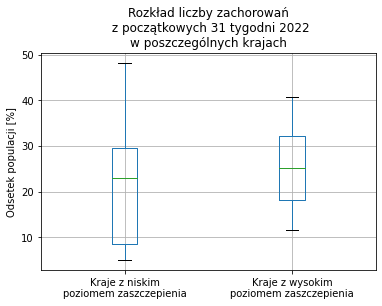

In [8]:
def to_country_level_data_frame(df):
    #Only cases and deaths from 2022 (till 32nd week), earlier vaccination level was lower
    by_country = df[df.year >= 2022].groupby(df.country).agg({
        'cases':['sum','max'], 
        'deaths':['sum','max'], 
        'popData2020':'median'
    })
    by_country.columns = by_country.columns.to_flat_index().str.join('_')
    #Which percent of the population is the number of cases and deaths
    by_country = by_country.assign(
        cases_prc = 100 * by_country.cases_sum / by_country.popData2020_median,
        deaths_prc = 100 * by_country.deaths_sum / by_country.popData2020_median,
        max_cases_prc = 100 * by_country.cases_max / by_country.popData2020_median,
        max_deaths_prc = 100 * by_country.deaths_max / by_country.popData2020_median
    )
    by_country = by_country.reset_index()
    h = by_country[by_country.country.isin(HIGH_VAC_COUNTRIES)]
    l = by_country[by_country.country.isin(LOW_VAC_COUNTRIES)]
    return h.assign(poziom = 'wysoki').append(l.assign(poziom = 'niski'))


def boxplot_group_by_level(df, variable, desc):
    ax = df[[variable,'poziom']].groupby('poziom').boxplot(subplots=False)
    ax.set_xticks(ticks=[1,2])
    ax.set_xticklabels(['Kraje z niskim\npoziomem zaszczepienia','Kraje z wysokim\npoziomem zaszczepienia'])
    ax.set_title(f'{desc}\n z początkowych 31 tygodni 2022\nw poszczególnych krajach')
    ax.set_ylabel('Odsetek populacji [%]')

    
a = to_country_level_data_frame(load_weekly_cases())

print(a.groupby(a.poziom).agg({
    'cases_prc':['mean','median'],
    'deaths_prc':['mean','median']
}))

boxplot_group_by_level(a, 'cases_prc', 'Rozkład liczby zachorowań')


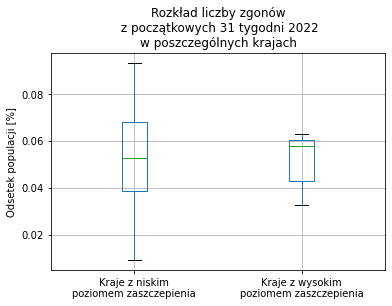

In [9]:
a = to_country_level_data_frame(load_weekly_cases())
boxplot_group_by_level(a, 'deaths_prc', 'Rozkład liczby zgonów')


W toku zmagań z pandemią często pojawiał się pogląd, że największym zagrożeniem jest szczyt pandemii, bo może doprowadzić do załamania systemu opieki zdrowotnej. Przyjrzyjmy się więc analogicznym statystykom dla wartości maksymalnych. Czyli w miejsce skumulowanej liczby przypadków z początkowych 31 tygodniu roku 2022, analizowane będą liczby przypadków z tego tygodnia spośród tych 31, w którym przypadków było najwięcej.

Jak widać poniżej, najgorszy tydzień zarówno pod względem liczby nowych przypadków jak i pod względem liczby zgonów był zauważalnie gorszy w krajach z niższym poziomem zaszczepienia społeczeństwa. Sprawdźmy więc (przy pomocy testu t (https://pl.wikipedia.org/wiki/Rozk%C5%82ad_Studenta#Zastosowania)) czy różnica ta jest istotna statystycznie.


       max_cases_prc          max_deaths_prc          
                mean   median           mean    median
poziom                                                
niski       2.777457  2.62740       0.005908  0.006082
wysoki      2.601170  2.12935       0.004661  0.004597


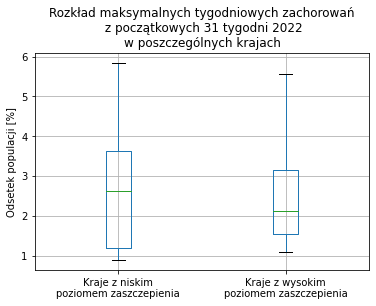

In [10]:
a = to_country_level_data_frame(load_weekly_cases())

print(a.groupby(a.poziom).agg({
    'max_cases_prc':['mean','median'],
    'max_deaths_prc':['mean','median']
}))

boxplot_group_by_level(a, 'max_cases_prc', 'Rozkład maksymalnych tygodniowych zachorowań')

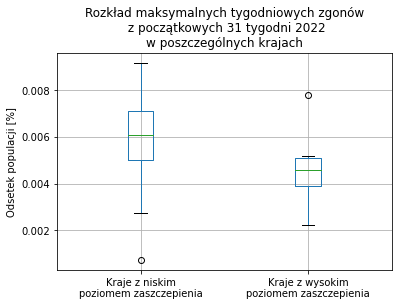

In [15]:
a = to_country_level_data_frame(load_weekly_cases())

boxplot_group_by_level(a, 'max_deaths_prc', 'Rozkład maksymalnych tygodniowych zgonów')

In [12]:
a = to_country_level_data_frame(load_weekly_cases())
print(f"t-test odnośnie maksymalnej liczby zachorować: {ttest_ind(a[a.poziom=='wysoki'].max_cases_prc, a[a.poziom=='niski'].max_cases_prc)}")
print(f"t-test odnośnie maksymalnej liczby zgonów: {ttest_ind(a[a.poziom=='wysoki'].max_deaths_prc, a[a.poziom=='niski'].max_deaths_prc)}")

t-test odnośnie maksymalnej liczby zachorować: Ttest_indResult(statistic=-0.23626602460606455, pvalue=0.8157545665214521)
t-test odnośnie maksymalnej liczby zgonów: Ttest_indResult(statistic=-1.1973536131525007, pvalue=0.2458941964379243)


Przy pomocy testu zbadamy dwie hipotezy. Pierwsza to: "Nie istnieje istotna różnica pomiędzy maksymalną tygodniową liczbą zachorowań w krajach z wysokim poziomem zaszczepienia i krajach z niskim poziomem zaszczepienia". Test ustali czy dane pozwalają na odrzucenie tej hipotezy i przyjęcie alternatywnej, tj.: "Istnieje istotna różnica pomiędzy badanymi grupami krajów". Druga hipoteza to: "Nie istnieje istotna różnica pomiędzy maksymalną tygodniową liczbą zgonów w krajach z wysokim poziomem zaszczepienia i krajach z niskim poziomem zaszczepienia". I tu również z pomocą testu będziemy ustalać możliwość przyjęcia alternatywnej hipotezy mówiącej o tym że taka różnica istnieje.

Wartość p dla maksymalnej tygodniowej liczby zachorowań wyniosła 0.82, a dla zgonów p = 0.24. Są więc większe od powszechnie przyjmowanego poziomu istotności $\alpha$ = 0.05, co oznacza że dane nie pozwalają na odrzucenie hipotezy o równości wartości średniej w badanych grupach. Czyli, że nie mamy podstaw do odrzucenia poglądu, że maksymalna liczba zachorować w tygodniu w grupie krajów z niskim poziomem zaszczepieniem jest taka sama jak w grupie krajów z wysokim poziomem Podobnie sytuacja wygląda w przypadku maksymalnej tygodniowej liczby zgonów.

Nie udało się uchwycić statystycznie istotnego wpływu poziomu zaszczepienia na drodze porównania krajów o różnym poziomie. Kraje jednak różnią się również wieloma innymi czynnikami, które mogą mieć wpływ zarówno na liczbę zachorowań jak i liczbę zgonów.

# Analiza korelacji pomiędzy poziomem zaszczepienia a zachorowaniami i zgonami

Spróbujmy zatem przyjrzeć się korelacji pomiędzy poziomem zaszczepienia populacji kraju, a liczbą zachorowań i zgonów po upływie pewnego czasu. Bez przesądzania ile czasu powinno upłynąć możemy skorzystać z tego, że komputer takie obliczenia potrafi przeprowadzić szybko i sprawdzić kilka wariantów ustalając kiedy korelacja będzie minimalna (spodziewamy się negatywnej korelacji, tj. im więcej szczepionek tym mniej zgonów). Nie zaszkodzi tu przypomnieć, że korelacja przyjmuje wartości z przedział od -1 do 1. Wartości skrajne oznaczają, że dwie badane wartości od siebie zależą, aczkolwiek dla -1 jest to zależność odwrotna, tj. gdy jedna rośnie to druga maleje (i na odwrót). Wartość równa zero oznacza brak zależności. Przez zależność należy rozumieć współwystępowanie. Korelacja nie jest w stanie wykazać, że jedna wielkość wpływa na drugą. Wartości skrajne korelacji trudno uzyskać w świecie rzeczywistym (może poza badaniem praw fizyki), bo w świecie rzeczywistym zawsze są jakieś nieuwzględnione czynniki zakłócające. Można więc spokojnie przyjąć, że uzyskując wartość korelacji w okolicach 0.5 (w naszym przypadku powinno to raczej być -0.5) odkrylibyśmy bardzo silną zależność.

Poniższy wykres ilustruje jak się zmieniała korelacja pomiędzy poziomem zaszczepienia populacji drugą dawką, a tygodniową liczbą zgonów po upływie zadanej liczby tygodni. Badane przesunięcie czasowe to przedział od 3 do 30 tygodni.

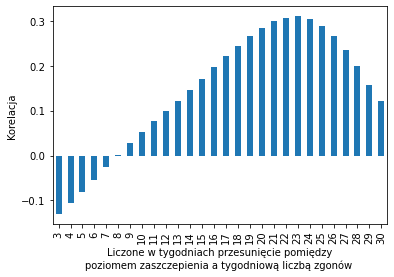

In [13]:
def shift_each_country(df, shift):
    shifted_df_c = pd.DataFrame()
    for c in df.country.unique():
        df_country = df[df.country == c]
        shifted_df_country = df_country.assign(
            cases_after = lambda x: 100 * x.cases.shift(shift) / x.popData2020,
            deaths_after = lambda x: 100 * x.deaths.shift(shift) / x.popData2020
        )
        shifted_df_country = shifted_df_country.dropna()
        shifted_df_c = shifted_df_c.append(shifted_df_country)
    return shifted_df_c


def shift_driven_correlation(df_v, df_c):
    idx = []
    values = []
    for shift in range(-30, -2):
        shifted_df_c = shift_each_country(df_c, shift)
        merged = shifted_df_c.merge(df_v, left_on=['country','year','week'], right_on=['country','year','week'])
        correlations = merged[['cases_after','deaths_after','Second']].corr(method='spearman')
        #print(f"{shift}: {correlations}")
        idx.append(-1*shift)
        values.append(correlations[['Second']].loc['deaths_after'].values[0])
    return pd.DataFrame({'korelacja':values}, index=idx)    
    
   
def plot_correlation_agaisnt_shift():
    corr_over_shift = shift_driven_correlation(load_weekly_vaccinations(), load_weekly_cases())
    corr_over_shift.sort_index(ascending=True).plot(kind='bar')
    plt.legend().remove()
    plt.ylabel('Korelacja')
    plt.xlabel('Liczone w tygodniach przesunięcie pomiędzy\npoziomem zaszczepienia a tygodniową liczbą zgonów ')
    
   
plot_correlation_agaisnt_shift()

Regularność uzyskanego wykresu jest podejrzana. Obawiając się błędu w obliczeniach wyrywkowo weryfikowałem wyniki w arkuszu kalkulacyjnym i żadnych nieprawidłowości nie zidentyfikowałem. Myślę więc, że można przyjąć, że faktycznie tak dane wyglądają.

Najniższa korelacja pomiędzy liczbą zgonów a poziomem zaszczepienia populacji dwiema dawkami występuje na początku badanego okresu, czyli (upraszczając) 3 tygodnie po zaszczepieniu mamy najniższą śmiertelność. Przypominam, że chodzi tu o poziom zaszczepienia całego społeczeństwa, więc niektóre osoby mogły się zaszczepić o wiele wcześniej. Taki wynik budzi wątpliwości, czy nie uchwyciliśmy przypadkiem jakiegoś innego efektu, np. relacji odwrotnej do tej której szukamy - wzrastająca liczba zachorowań i zgonów generuje strach, który staje się czynnikiem motywującym do zaszczepienia się. Co prawda mamy przesunięcie czasowe, ale jeżeli trendy cechują się dużą bezwładnością, to możemy taki wynik uzyskać pomimo przesunięcia. To są oczywiście tylko spekulacje, nie ma dowodów empirycznych że właśnie taki związek przyczynowo skutkowy zaistniał. Niemniej, pokazuje to, że z całą pewnością nie wyeliminowaliśmy ani innych interpretacji ani zmiennych zakłócających (mających wpływ na badane wielkości, a nie ujętych w analizie). Warto mieć to z tyłu głowy interpretując kolejną, ostatnią już analizę.

Na poniższej ilustracji widzimy zestawienie współczynników korelacji dla poszczególnych krajów pokazujących powiązanie pomiędzy procentowym poziomem zaszczepienia kraju a jedną z trzech zmiennych opisujących skutki pandemii po upływie trzech tygodni od momentu zmierzenia poziomu zaszczepienia:
- tygodniowej liczby zgonów przedstawionej jako odsetek populacji
- tygodniowej liczby zachorowań przedstawionej jako odsetek populacji
- stosunek pomiędzy powyższymi, czyli zgonów podzielonych przez zachorowania (nie jest to statystyka mająca klarowne przełożenie na świat rzeczywisty, ale jest czynnikiem gdzie na podstawie wcześniejszych wykresów możemy się spodziewać ciekawych wyników)


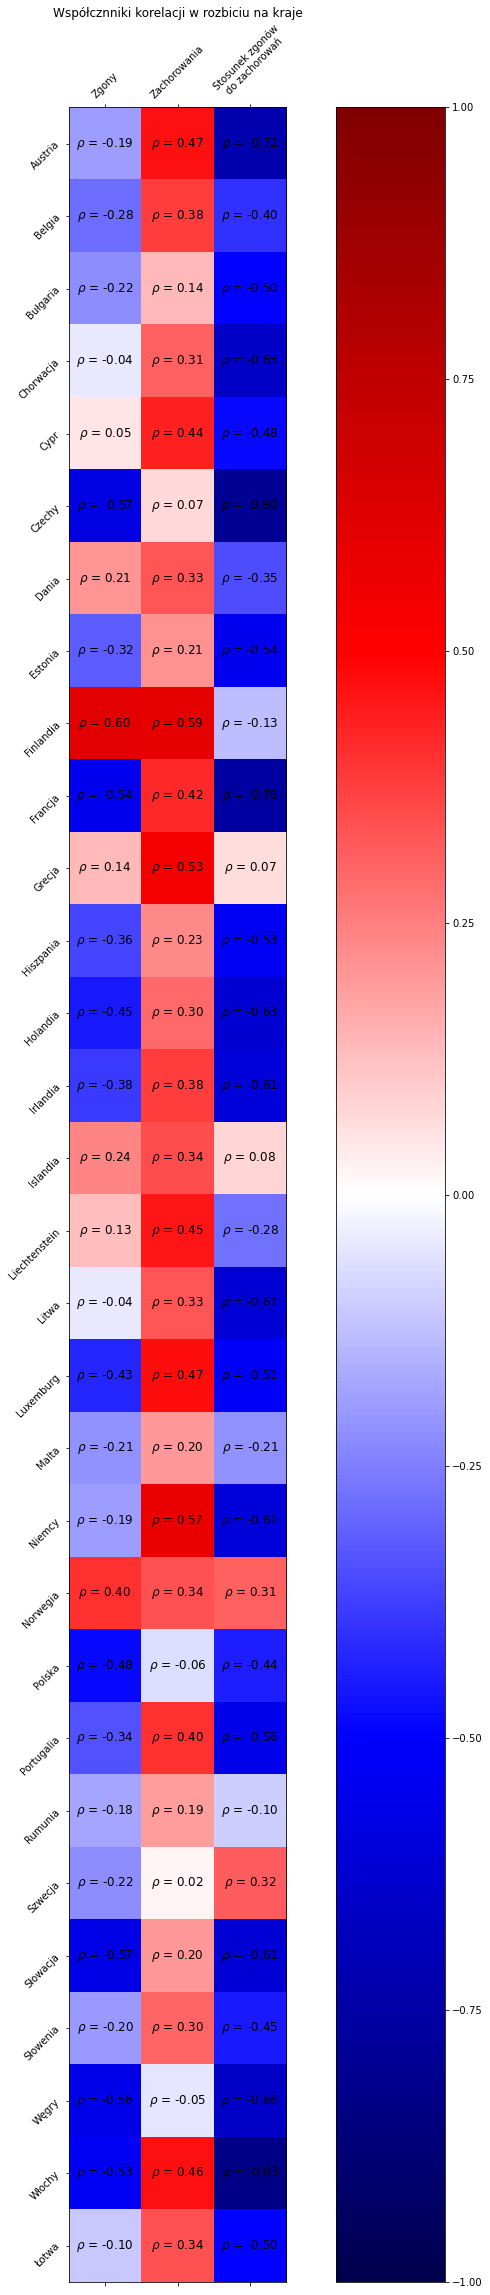

In [14]:
df_v = load_weekly_vaccinations()
df_c = load_weekly_cases()
shifted = shift_each_country(df_c, -3)
merged = shifted.merge(df_v, left_on=['country','year','week'], right_on=['country','year','week'])

merged = merged.assign(
    cases_to_deaths = merged.deaths_after / merged.cases_after 
)
fig, ax = plt.subplots(figsize=(18, 40))
deaths_corr = merged[['country','Second','deaths_after', 'cases_after', 'cases_to_deaths']].groupby('country').corr()
deaths_corr = deaths_corr[['deaths_after', 'cases_after', 'cases_to_deaths']]
deaths_corr = deaths_corr[deaths_corr.index.isin(['Second'], level=1)]
deaths_corr.index = deaths_corr.index.droplevel(1)

im = ax.matshow(deaths_corr, cmap='seismic')
im.set_clim(-1, 1)
fig.colorbar(im)

ax.set_yticks([*range(0,30)])
ax.set_yticklabels(deaths_corr.index.tolist(), rotation=45)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Zgony','Zachorowania','Stosunek zgonów\ndo zachorowań'], rotation=45)
ax.set_title('Współcznniki korelacji w rozbiciu na kraje')

for (i, j), coef in np.ndenumerate(deaths_corr):
    ax.text(j, i, fr'$\rho$ = {coef:.2f}', ha='center', va='center', color='black', fontsize=12)

Wyniki dosyć istotnie różnią się pomiędzy krajami. Niemniej możemy z dużą dozą pewności stwierdzić, że poziom zaszczepienia nie przekłada się na niską liczbę zachorować (dla większości krajów uzyskaliśmy pozytywną korelację). Odnośnie liczby zgonów sytuacja nie jest taka jednoznaczna, mamy przewagę korelacji ujemnych, ale są też takie kraje jak Norwegia czy Finlandia gdzie coś ewidentnie poszło nie tak. I w końcu nasz sztucznie spreparowany stosunek. Zgodnie z przewidywaniami wychodzi tu najlepiej i zaobserwowane dane mogą przekonywać o jego powiązaniu z poziomem zaszczepienia. No ale co z tego skoro składową tej relacji jest pozytywna korelacja z poziomem zachorowań, co zdecydowanie nie jest pożądanym efektem.

# Podsumowanie
Wyniki wychodzą jak z profesjonalnego, naukowego badania, czyli są niejednoznaczne i wymagają dalszych eksperymentów oraz analiz. Są pewne przesłanki sugerujący pozytywny wpływ poziomu zaszczepienia, ale nie udało się wykazać ich istotności. Prawdopodobnie istnieją inne czynniki, które mają większy wpływ na poziomy zachorowań i zgonów, a których w tej analizie nie badałem. Niestety skłania to do raczej smutnej konkluzji. Mianowicie, że szczepienia nie są czynnikiem, który mógłby samodzielnie doprowadzić do zakończenia pandemii.

Przedstawione analizy dotyczyły populacji, a nie poszczególnych osób, dla których efekt szczepienia może być zupełnie inny. Nie są więc wartościową przesłanką przy podejmowaniu decyzji o szczepieniu się i w związku z tym nie zalecam wykorzystywania ich w taki sposób. Należy je raczej traktować jak ciekawostkę dostarczającą teoretycznych informacji na temat pewnych aspektów przebiegu pandemii.

Cała analiza jest dostępna online: https://github.com/mjureczko/covid-statistics.